In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import random

from scipy.integrate import solve_ivp
import torch 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import pysindy as ps

In [2]:
# Чтобы при вызове print или display после точки выводилось фиксированное число знаков

# np.set_printoptions(precision=5, suppress=True)

# Генерация наших данных

Начальные концентрации:        [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Сумма концентрций веществ:  0.9999999999999999
[5.19498155e-06 1.54594957e-03 1.80646380e-03 6.22171901e-07
 3.98887190e-06]


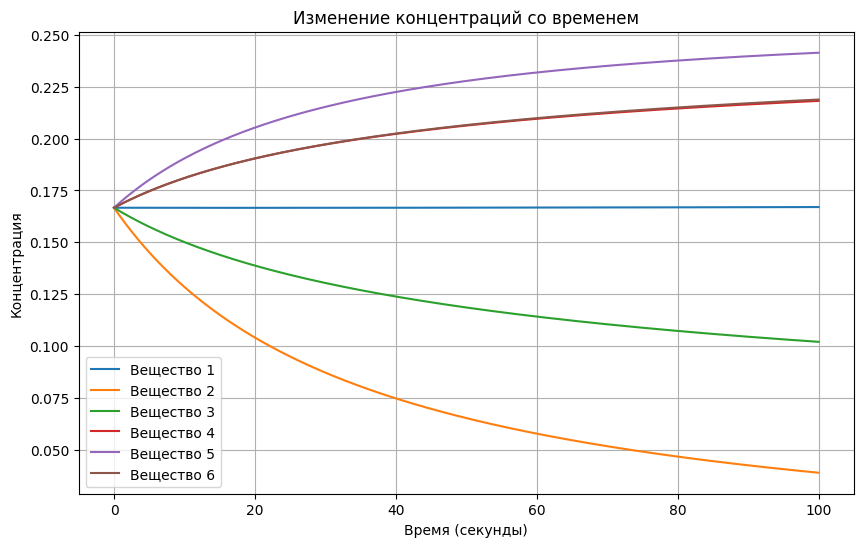

Концентрации после 100 секунд: [0.16699309 0.03907172 0.1021     0.21811198 0.24130944 0.21876702]
Сумма концентрций веществ:  0.9863532425341756


In [3]:
# random.seed(1)

# Константы
N_REACTION = 5                                                                # реакций
N_SUBSTANCE = 6                                                               # веществ
A = np.array([100000000, 90000000, 85000000, 110000000, 95000000])
Ea= np.array([70000, 60000, 55000, 80000, 75000])
R = 8.314
temp = 300
vr_time = 100
H = 0.01
MATR = np.array([
    [-2, -1, 1, 1, 0, 0],
    [0, -2, 1, 0, 2, 0],
    [0, -1, -2, 1, 0, 1],
    [1, 0, 0, -2, 1, 0],
    [1, 0, 0, 0, -2, 1]
])

# Матрица порядков реакций
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
k = A * np.exp(-Ea / (R * temp)) * (temp**0.5)

# Переменные, будут заводиться отдельно
C = np.full(N_SUBSTANCE, 1 / N_SUBSTANCE)
print("Начальные концентрации:       ", C)
print("Сумма концентрций веществ: ", sum(C))

# Список для хранения концентраций на каждом шаге времени
concentration_history = [C.copy()]

print(np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(N_REACTION)]))

def dC_dt(C):
    W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(N_REACTION)])  # Скорость для каждой реакции
    dC = MATR.T @ W  # Изменение концентраций
    return dC

time_steps = int(vr_time / H)
for _ in range(time_steps):
    dC = dC_dt(C)
    C += dC * H
    concentration_history.append(C.copy())

concentration_history = np.array(concentration_history)

# Построение графика
time = np.linspace(0, vr_time, time_steps + 1)
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(time, concentration_history[:, i], label=f"Вещество {i+1}")

plt.title("Изменение концентраций со временем")
plt.xlabel("Время (секунды)")
plt.ylabel("Концентрация")
plt.legend()
plt.grid()
plt.show()

print(f"Концентрации после {vr_time} секунд: {C}")
print("Сумма концентрций веществ: ", sum(C))


# Генерация данных нашим подходом, но для CRNN-модели

In [45]:
N_REACTION = 4                                                               # реакций
N_SUBSTANCE = 5                                                              # веществ
vr_time = 100
H = 0.01
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

# Матрица порядков реакций
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)

# Переменные, будут заводиться отдельно
C0 = np.array([0.4, 0.6, 0, 0, 0])
C = np.array([0.4, 0.6, 0, 0, 0])

# Список для хранения концентраций на каждом шаге времени
concentration_history = [C.copy()]


W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(N_REACTION)])  # Скорость для каждой реакции
dC = MATR.T @ W  # Изменение концентраций

In [47]:
print(W)
print(dC)

[0.016      0.08000001 0.         0.        ]
[-0.11200001  0.016       0.08000001  0.          0.        ]


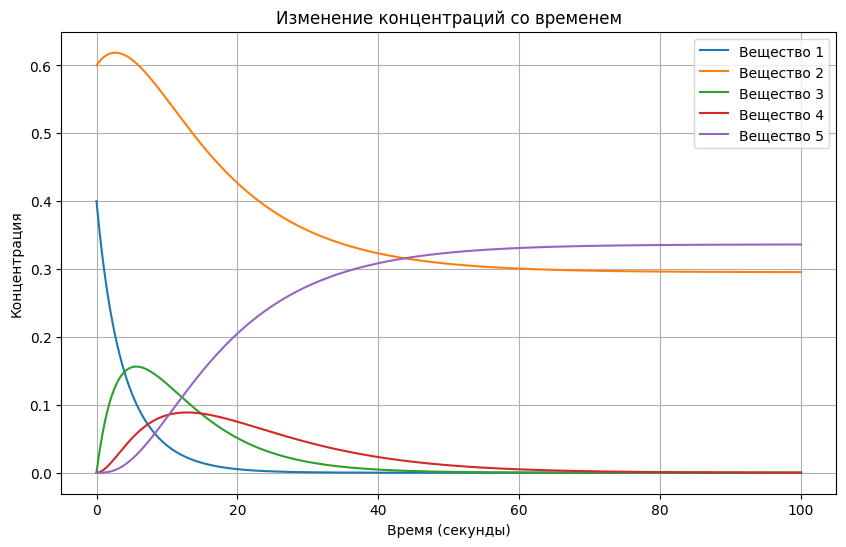

Начальные концентрации:        [0.4 0.6 0.  0.  0. ]
Сумма концентрций веществ:  1.0
Концентрации после 100 секунд: [5.76835235e-10 2.95556209e-01 1.99073588e-06 1.67152430e-04
 3.36239480e-01]
Сумма концентрций веществ:  0.6319648320602071


In [4]:
# random.seed(1)

# Константы
N_REACTION = 4                                                               # реакций
N_SUBSTANCE = 5                                                              # веществ
vr_time = 100
H = 0.01
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

# Матрица порядков реакций
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)

# Переменные, будут заводиться отдельно
C0 = np.array([0.4, 0.6, 0, 0, 0])
C = np.array([0.4, 0.6, 0, 0, 0])

# Список для хранения концентраций на каждом шаге времени
concentration_history = [C.copy()]

def dC_dt(C):
    W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(N_REACTION)])  # Скорость для каждой реакции
    dC = MATR.T @ W  # Изменение концентраций
    return dC

time_steps = int(vr_time / H)
for _ in range(time_steps):
    dC = dC_dt(C)
    C += dC * H
    concentration_history.append(C.copy())

concentration_history = np.array(concentration_history)

# Построение графика
time = np.linspace(0, vr_time, time_steps + 1)
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(time, concentration_history[:, i], label=f"Вещество {i+1}")

plt.title("Изменение концентраций со временем")
plt.xlabel("Время (секунды)")
plt.ylabel("Концентрация")
plt.legend()
plt.grid()
plt.show()

print("Начальные концентрации:       ", C0)
print("Сумма концентрций веществ: ", sum(C0))

print(f"Концентрации после {vr_time} секунд: {C}")
print("Сумма концентрций веществ: ", sum(C))


# Вариант генерации в CRNN-модели

Далее идут 3 теста генерации изменений концентарций со временем с разными начальными концентрациями веществ

## Test 1

In [5]:
def true_ode_func(t, y, k):
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : array-like
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : array-like
        Коэффициенты (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    dydt = np.zeros_like(y)
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

In [6]:
# Константы
N_REACTION = 4                                                               # реакций
N_SUBSTANCE = 5                                                              # веществ
vr_time = 50                                                                # время прохождения реакций

k = torch.tensor([0.1, 0.2, 0.13, 0.3], dtype=torch.float32)
C0 = np.array([0.4, 0.6, 0, 0, 0])                                           # начальные концентрации
C = np.array([0.4, 0.6, 0, 0, 0])

tspan = [0.0, vr_time]                                                       # временной промежуток
tsteps = np.linspace(tspan[0], tspan[1], vr_time * 4)                                 # шаги по временному промежутку

sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        C,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

conc_hist = sol.y

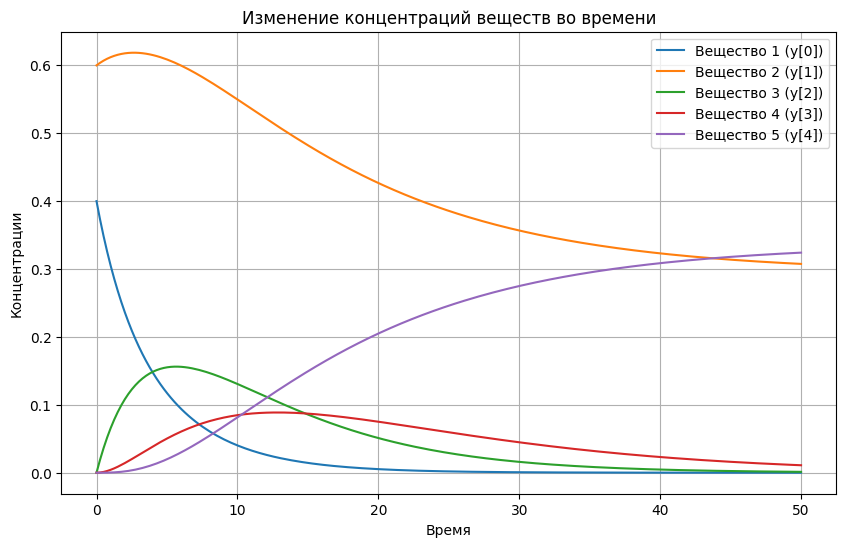

Начальные концентрации:        [0.4 0.6 0.  0.  0. ]
Сумма концентраций веществ:  1.0
Концентрации после 50 секунд: [0.02495955 0.51781497 0.10944508 0.08859621 0.11378974]
Сумма концентрций веществ:  0.8546055496714939


In [8]:
# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", C0)
print("Сумма концентраций веществ: ", sum(C0))

print(f"Концентрации после {vr_time} секунд: {sol.y[:, vr_time - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, vr_time - 1]))


## Test 2

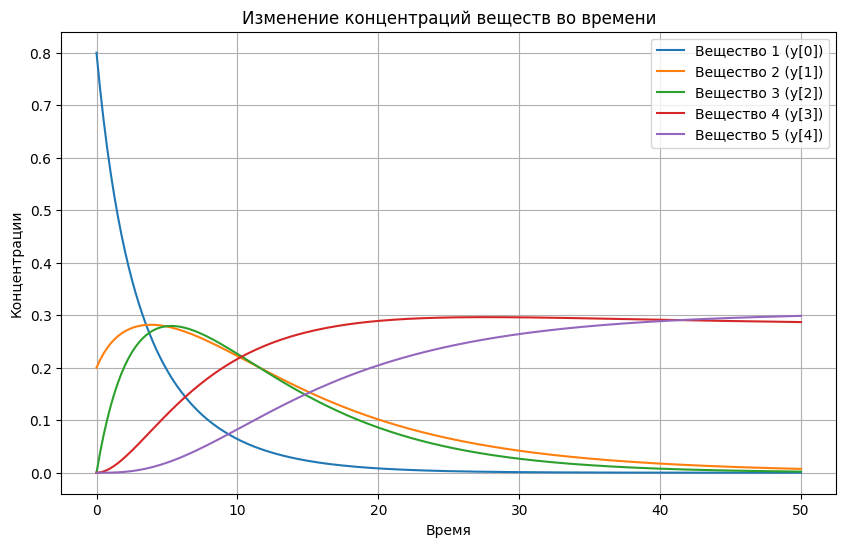

Начальные концентрации:        [0.8 0.2 0.  0.  0. ]
Сумма концентраций веществ:  1.0
Концентрации после 50 секунд: [0.03940547 0.18984074 0.18765572 0.24573059 0.11584225]
Сумма концентрций веществ:  0.7784747623437238


In [9]:
start_conc_1 = np.array([0.8, 0.2, 0, 0, 0])
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        start_conc_1,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", start_conc_1)
print("Сумма концентраций веществ: ", sum(start_conc_1))

print(f"Концентрации после {vr_time} секунд: {sol.y[:, vr_time - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, vr_time - 1]))


## Test 3

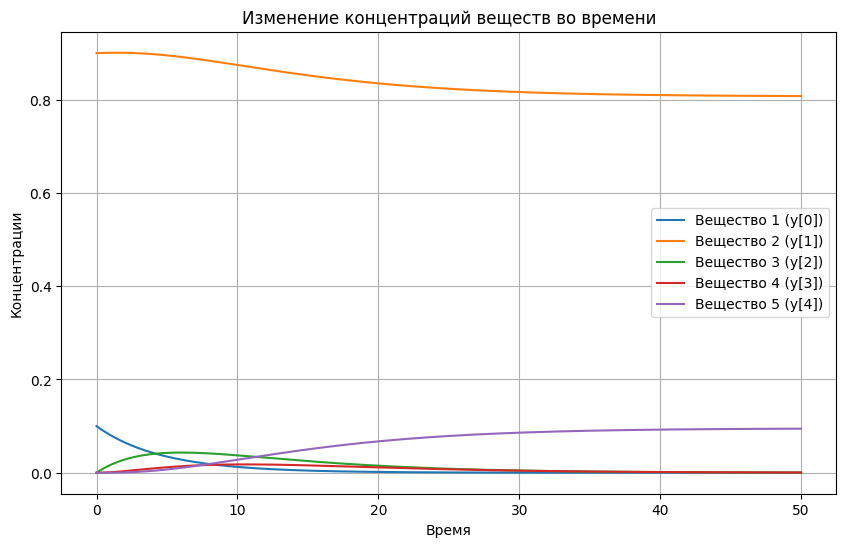

Начальные концентрации:        [0.1 0.9 0.  0.  0. ]
Сумма концентраций веществ:  1.0
Концентрации после 50 секунд: [0.00781081 0.86380216 0.03153197 0.01747113 0.03852726]
Сумма концентрций веществ:  0.959143326334844


In [10]:
start_conc_2 = np.array([0.1, 0.9, 0, 0, 0])
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        start_conc_2,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", start_conc_2)
print("Сумма концентраций веществ: ", sum(start_conc_2))

print(f"Концентрации после {vr_time} секунд: {sol.y[:, vr_time - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, vr_time - 1]))


## Test 4

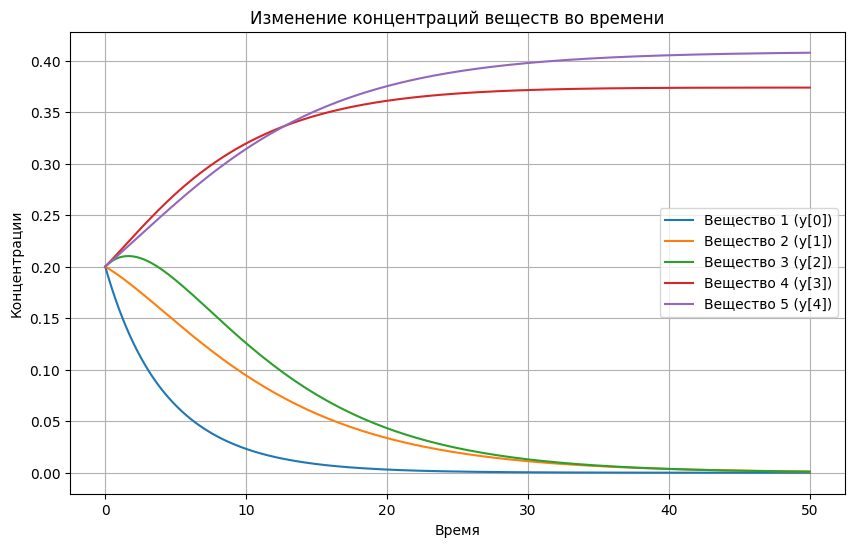

Начальные концентрации:        [0.2 0.2 0.2 0.2 0.2]
Сумма концентраций веществ:  1.0
Концентрации после 50 секунд: [0.01443435 0.07528875 0.1003474  0.33426767 0.33345769]
Сумма концентрций веществ:  0.8577958640349355


In [11]:
start_conc_3 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        start_conc_3,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", start_conc_3)
print("Сумма концентраций веществ: ", sum(start_conc_3))

print(f"Концентрации после {vr_time} секунд: {sol.y[:, vr_time - 1]}")
print("Сумма концентрций веществ: ", sum(sol.y[:, vr_time - 1]))


## Построение полиномиальных функций с помощью регрессии

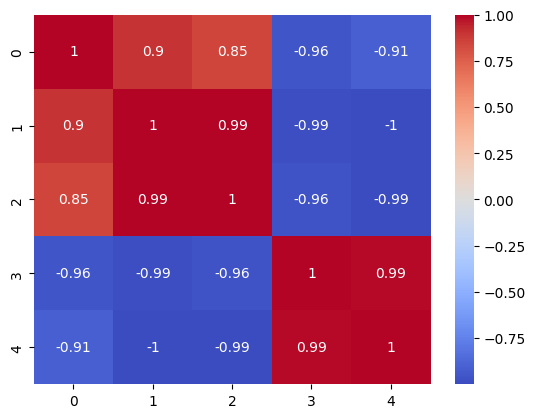

In [27]:
corr_matrix = np.corrcoef(sol.y)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Для всех концентраций лучшим приближением будет полином 8 степени

Далее представлен блок кода, который выполняет полиномиальное приближение изменения концентрации каждого вещества во времени на основе данных последнего теста с использованием регрессии

Для C0 вещества:
Коэффициент детерминации R^2: 0.99989369
Коэффициенты полинома:
[[ 0.00000000e+00 -4.39144588e-02  4.66350876e-03 -2.89534830e-04
   1.08484523e-05 -2.39277265e-07  2.84593976e-09 -1.40373546e-11]]
Свободный член: 0.19780498

Для C1 вещества:
Коэффициент детерминации R^2: 0.99999729
Коэффициенты полинома:
[[ 0.00000000e+00 -8.88234495e-03 -7.45073988e-04  8.69358334e-05
  -3.76812709e-06  8.58470130e-08 -1.01754805e-09  4.94549020e-12]]
Свободный член: 0.20044720

Для C2 вещества:
Коэффициент детерминации R^2: 0.99996024
Коэффициенты полинома:
[[ 0.00000000e+00  1.00087821e-02 -3.92482355e-03  3.20524566e-04
  -1.31495196e-05  2.99100746e-07 -3.58835108e-09  1.77021210e-11]]
Свободный член: 0.20217738

Для C3 вещества:
Коэффициент детерминации R^2: 0.99998169
Коэффициенты полинома:
[[ 0.00000000e+00  1.60006002e-02 -1.55982556e-04 -4.51215093e-05
   2.83125727e-06 -7.67874753e-08  1.01562735e-09 -5.33005237e-12]]
Свободный член: 0.19898905

Для C4 вещества:
Коэффициент

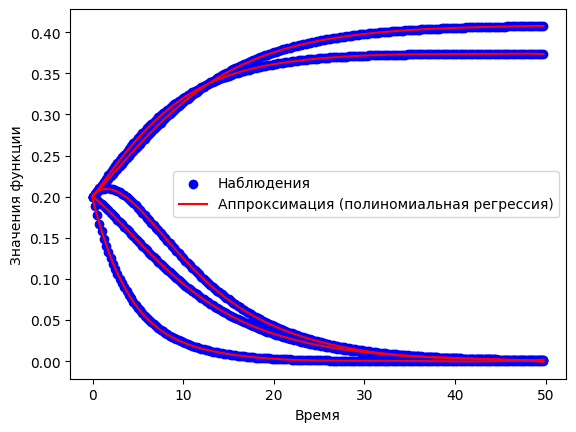

In [ ]:
# Вектор значений по времмени с шагом
time_vec = np.array([i/4  for i in range(vr_time * 4)])  # шаг = i/4 = 0,25 секунды

# Преобразование данных в нужный формат для scikit-learn
time_vec = time_vec.reshape(-1, 1)  # моменты времени как 2D массив

# Преобразование признаков в полиномиальные
poly = PolynomialFeatures(degree=7)
t_poly = poly.fit_transform(time_vec)

for i in range(N_SUBSTANCE):
    y = sol.y[i].reshape(-1, 1)  # значения функции как 2D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # Параметры модели
    r2 = model.score(t_poly, y)
    print(f"Для C{i} вещества:")
    print(f"Коэффициент детерминации R^2: {r2:.8f}")
    print("Коэффициенты полинома:")
    print(model.coef_)
    print(f"Свободный член: {model.intercept_[0]:.8f}")
    print("=" * 50)  # разделитель
    print()

    if i == 0:
        # Визуализируем данные и аппроксимацию
        plt.scatter(time_vec, y, color='blue', label='Наблюдения')
        plt.plot(time_vec, y_pred, color='red', label='Аппроксимация (полиномиальная регрессия)')
    else:
        plt.scatter(time_vec, y, color='blue')
        plt.plot(time_vec, y_pred, color='red')

plt.xlabel('Время')
plt.ylabel('Значения функции')
plt.legend()
plt.show()




$$ С0(t) = 0.19780 − 0.0439144588⋅t + 0.00466350876⋅t^{2} − 0.00028953483⋅t^{3} + 1.08484523⋅10^{−5}⋅t^{4} − 2.39277265⋅10^{−7}⋅t^{5} + 2.84593976⋅10^{−9}⋅t^{6} − 1.40373546⋅10^{−11}⋅t^{7} $$


## Лог. регрессия

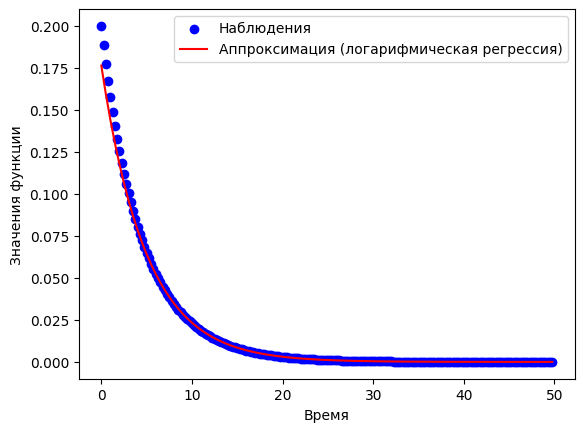

Коэффициент детерминации R^2: 0.9999023759405731

Коэффициенты логарифмической регрессии: a = [0.17636695], b = [-0.20226252]


In [121]:
time_vec = np.array([i/4 + 0.00000000001  for i in range(vr_time * 4)])
y = sol.y[0].reshape(-1, 1)  # значения функции как 2D массив

log_y = np.log(y)
time_vec = time_vec.reshape(-1, 1)

# Создаем и обучаем модель линейной регрессии
model = LinearRegression()
model.fit(time_vec, log_y)

# Получаем параметры модели
log_a = model.intercept_  # ln(a)
a = np.exp(log_a)
b = model.coef_[0]  # коэффициент b

y_pred = np.exp(model.predict(time_vec))

# Визуализируем данные и аппроксимацию
plt.scatter(time_vec, y, color='blue', label='Наблюдения')
plt.plot(time_vec, y_pred, color='red', label='Аппроксимация (логарифмическая регрессия)')
plt.xlabel('Время')
plt.ylabel('Значения функции')
plt.legend()
plt.show()

# Выводим результаты
r2 = model.score(time_vec, log_y)
print(f"Коэффициент детерминации R^2: {r2}")
print()
print(f"Коэффициенты логарифмической регрессии: a = {a}, b = {b}")

Лог. регрессия адекватно работает только для C0 вещества. Если мы априорно не знаем изменения концентрации вещества, то подогнать логарифмом проблематично